<a href="https://colab.research.google.com/github/Aayush-ujjwal/major-project/blob/main/Major_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import random
import math
import csv

In [ ]:
import pandas as pd
import random
import math

# Define the number of entries in the dataset
num_entries = 1000

# Define the ranges for each feature
speed_range = (20, 100)  # Kmph
acceleration_range = (1, 3)  # m/s²
elevation_change_range = (-50, 50)  # meter (positive for uphill, negative for downhill)
temperature_range = (-10, 40)  # °C
weather_conditions = ['Sunny', 'Rainy', 'Cloudy']
hvac_usage = [0, 1]  # 0: No HVAC, 1: HVAC in use
battery_health_range = (80, 100)  # %
state_of_charge_range = (20, 100)  # %
driving_modes = ['Eco', 'Normal', 'Sport']
range_range = (100, 500)  # Km
optimum_velocity_range = (30, 80)  # Kmph
optimum_acceleration_range = (1, 2.5)  # m/s²

# Generate the dataset
dataset = []
for _ in range(num_entries):
    speed = random.uniform(*speed_range)
    acceleration = random.uniform(*acceleration_range)
    elevation_change = random.uniform(*elevation_change_range)
    temperature = None
    weather = random.choice(weather_conditions)
    hvac_usage_status = random.choice(hvac_usage)
    battery_health = random.uniform(*battery_health_range)
    state_of_charge = random.uniform(*state_of_charge_range)
    driving_mode = random.choice(driving_modes)
    range_value = random.uniform(*range_range)

    # Assign temperature based on weather conditions
    if weather == 'Sunny':
        temperature = random.uniform(25, 50)
    elif weather == 'Cloudy':
        temperature = random.uniform(20, 35)
    elif weather == 'Rainy':
        temperature = random.uniform(15, 25)

    h = math.sqrt((elevation_change * elevation_change) + (50 * 50))
    sinA = elevation_change / h

    if elevation_change > 3:
        if speed < 40:
            optimum_velocity = random.uniform(40, 55)
        else:
            optimum_velocity = random.uniform(45, 60)
    elif elevation_change < -3:
        optimum_velocity = random.uniform(20, 40)
        acceleration = random.uniform(-3, -1)  # Set negative acceleration
    else:
        if speed < 40:
            optimum_velocity = random.uniform(40, 50)
        else:
            optimum_velocity = random.uniform(50, 70)

    optimum_acceleration = ((optimum_velocity ** 2) - (speed ** 2)) / (2 * h)

    dataset.append([speed, acceleration, elevation_change, temperature, weather, hvac_usage_status,
                    battery_health, state_of_charge, driving_mode, range_value, optimum_acceleration, optimum_velocity])

# Create a DataFrame
df = pd.DataFrame(dataset, columns=["Speed (Kmph)", "Acceleration (m/s²)", "Elevation Change (meter)", "Temperature (°C)",
                                    "Weather Conditions", "HVAC Usage", "Battery Health (%)", "State of Charge(%)",
                                    "Driving Mode", "Range (Km)", "Optimum Acceleration (m/s²)", "Optimum Velocity"])

# Save DataFrame to CSV
df.to_csv("generated_dataset.csv", index=False)

print("Full dataset generated and saved to full_dataset.csv")

Full dataset generated and saved to full_dataset.csv


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Load dataset from CSV
dataset = pd.read_csv('/content/generated_dataset.csv')

# Encode the categorical columns
label_encoder = LabelEncoder()
dataset['Weather Conditions'] = label_encoder.fit_transform(dataset['Weather Conditions'])
dataset['Driving Mode'] = label_encoder.fit_transform(dataset['Driving Mode'])

# Rename columns to match the specified column names
dataset.columns = ["Speed (Kmph)", "Acceleration (m/s²)", "Elevation Change (meter)", "Temperature (°C)",
                   "Weather Conditions", "HVAC Usage", "Battery Health (%)", "State of Charge(%)",
                   "Driving Mode", "Range (Km)", "Optimum Acceleration (m/s²)", "Optimum Velocity"]

# Split data into features and target variable
X = dataset[['Speed (Kmph)', 'Acceleration (m/s²)', 'Elevation Change (meter)', 'Temperature (°C)', 'Weather Conditions',
             'HVAC Usage', 'Battery Health (%)', 'State of Charge(%)', 'Driving Mode', 'Range (Km)', 'Optimum Acceleration (m/s²)']].values
y = dataset['Optimum Velocity'].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape input data for LSTM
X_lstm = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y, test_size=0.3, random_state=42)

# Define models
rf_model = RandomForestRegressor()
et_model = ExtraTreesRegressor()
lstm_model = Sequential([
    LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(units=1)
])
lr_model = LinearRegression()

# Train models
rf_model.fit(X_train.reshape((X_train.shape[0], X_train.shape[1])), y_train)
et_model.fit(X_train.reshape((X_train.shape[0], X_train.shape[1])), y_train)
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=1000, batch_size=32)
lr_model.fit(X_train.reshape((X_train.shape[0], X_train.shape[1])), y_train)

# Predictions
rf_pred = rf_model.predict(X_test.reshape((X_test.shape[0], X_test.shape[1])))
et_pred = et_model.predict(X_test.reshape((X_test.shape[0], X_test.shape[1])))
lstm_pred = lstm_model.predict(X_test).flatten()
lr_pred = lr_model.predict(X_test.reshape((X_test.shape[0], X_test.shape[1])))

# Define weights for each model (can be based on validation performance)
rf_weight = 0.4
et_weight = 0.3
lstm_weight = 0.2
lr_weight = 0.1

Epoch 1/1000
22/22 [==============================] - 9s 23ms/step - loss: 1926.8132
Epoch 2/1000
22/22 [==============================] - 0s 22ms/step - loss: 1853.8561
Epoch 3/1000
22/22 [==============================] - 0s 22ms/step - loss: 771.0811
Epoch 4/1000
22/22 [==============================] - 0s 16ms/step - loss: 405.0061
Epoch 5/1000
22/22 [==============================] - 0s 22ms/step - loss: 282.0233
Epoch 6/1000
22/22 [==============================] - 1s 34ms/step - loss: 224.2121
Epoch 7/1000
22/22 [==============================] - 1s 29ms/step - loss: 174.2777
Epoch 8/1000
22/22 [==============================] - 0s 19ms/step - loss: 132.7494
Epoch 9/1000
22/22 [==============================] - 0s 14ms/step - loss: 104.3687
Epoch 10/1000
22/22 [==============================] - 0s 14ms/step - loss: 80.3566
Epoch 11/1000
22/22 [==============================] - 0s 13ms/step - loss: 67.5361
Epoch 12/1000
22/22 [==============================] - 0s 19ms/step - loss

In [ ]:
def evaluate_ensemble_prediction(ensemble_name, ensemble_pred, y_test):
    return {
        "Name": ensemble_name,
        "MAE": mean_absolute_error(y_test, ensemble_pred),
        "MSE": mean_squared_error(y_test, ensemble_pred),
        "R^2": r2_score(y_test, ensemble_pred)
    }

# Initialize ensemble_metrics dictionary
ensemble_metrics = {}

# Combine predictions from all models using weighted averaging
ensemble_pred_1 = (rf_weight * rf_pred)
ensemble_pred_2 = (et_weight * et_pred)
ensemble_pred_3 = (lstm_weight * lstm_pred)
ensemble_pred_4 = (lr_weight * lr_pred)

# Evaluate performance of each one-model ensemble
ensemble_metrics.update({
    'Ensemble (RF)': evaluate_ensemble_prediction("Ensemble (RF)", ensemble_pred_1, y_test),
    'Ensemble (ET)': evaluate_ensemble_prediction("Ensemble (ET)", ensemble_pred_2, y_test),
    'Ensemble (LSTM)': evaluate_ensemble_prediction("Ensemble (LSTM)", ensemble_pred_3, y_test),
    'Ensemble (LR)': evaluate_ensemble_prediction("Ensemble (LR)", ensemble_pred_4, y_test)
})

# Combine predictions from all models using weighted averaging
ensemble_pred_12 = (rf_weight * rf_pred + et_weight * et_pred)
ensemble_pred_13 = (rf_weight * rf_pred + lstm_weight * lstm_pred)
ensemble_pred_14 = (rf_weight * rf_pred + lr_weight * lr_pred)
ensemble_pred_23 = (et_weight * et_pred + lstm_weight * lstm_pred)
ensemble_pred_24 = (et_weight * et_pred + lr_weight * lr_pred)
ensemble_pred_34 = (lstm_weight * lstm_pred + lr_weight * lr_pred)

# Evaluate performance of each two-model ensemble
ensemble_metrics.update({
    'Ensemble (RF + ET)': evaluate_ensemble_prediction("Ensemble (RF + ET)", ensemble_pred_12, y_test),
    'Ensemble (RF + LSTM)': evaluate_ensemble_prediction("Ensemble (RF + LSTM)", ensemble_pred_13, y_test),
    'Ensemble (RF + LR)': evaluate_ensemble_prediction("Ensemble (RF + LR)", ensemble_pred_14, y_test),
    'Ensemble (ET + LSTM)': evaluate_ensemble_prediction("Ensemble (ET + LSTM)", ensemble_pred_23, y_test),
    'Ensemble (ET + LR)': evaluate_ensemble_prediction("Ensemble (ET + LR)", ensemble_pred_24, y_test),
    'Ensemble (LSTM + LR)': evaluate_ensemble_prediction("Ensemble (LSTM + LR)", ensemble_pred_34, y_test)
})

# Combine predictions from all models using weighted averaging
ensemble_pred_123 = (rf_weight * rf_pred + et_weight * et_pred + lstm_weight * lstm_pred)
ensemble_pred_124 = (rf_weight * rf_pred + et_weight * et_pred + lr_weight * lr_pred)
ensemble_pred_134 = (rf_weight * rf_pred + lstm_weight * lstm_pred + lr_weight * lr_pred)
ensemble_pred_234 = (et_weight * et_pred + lstm_weight * lstm_pred + lr_weight * lr_pred)

# Evaluate performance of each three-model ensemble
ensemble_metrics.update({
    'Ensemble (RF + ET + LSTM)': evaluate_ensemble_prediction("Ensemble (RF + ET + LSTM)", ensemble_pred_123, y_test),
    'Ensemble (RF + ET + LR)': evaluate_ensemble_prediction("Ensemble (RF + ET + LR)", ensemble_pred_124, y_test),
    'Ensemble (RF + LSTM + LR)': evaluate_ensemble_prediction("Ensemble (RF + LSTM + LR)", ensemble_pred_134, y_test),
    'Ensemble (ET + LSTM + LR)': evaluate_ensemble_prediction("Ensemble (ET + LSTM + LR)", ensemble_pred_234, y_test)
})

# Combine predictions from all models using weighted averaging
ensemble_pred_weighted = (rf_weight * rf_pred + et_weight * et_pred +
                          lstm_weight * lstm_pred + lr_weight * lr_pred)

# Evaluate performance of the weighted ensemble
ensemble_metrics['Ensemble (Weighted)'] = evaluate_ensemble_prediction("Ensemble (Weighted)", ensemble_pred_weighted, y_test)

# Print ensemble metrics
for name, metrics in ensemble_metrics.items():
    print(f"{metrics['Name']} Metrics:")
    print(f"MAE: {metrics['MAE']}")
    print(f"MSE: {metrics['MSE']}")
    print(f"R^2: {metrics['R^2']}")
    print()

Ensemble (RF) Metrics:
MAE: 25.52277635576956
MSE: 716.3007397682493
R^2: -3.9816555701002674

Ensemble (ET) Metrics:
MAE: 29.74282023437754
MSE: 966.820020763938
R^2: -5.723941599280502

Ensemble (LSTM) Metrics:
MAE: 34.01517005802308
MSE: 1249.8110195063746
R^2: -7.692058630165613

Ensemble (LR) Metrics:
MAE: 38.23475009143254
MSE: 1582.9419755806207
R^2: -10.008883939374455

Ensemble (RF + ET) Metrics:
MAE: 12.81755556010712
MSE: 194.71949977367854
R^2: -0.354215383008712

Ensemble (RF + LSTM) Metrics:
MAE: 17.06293252788616
MSE: 324.735657852333
R^2: -1.2584385425507785

Ensemble (RF + LR) Metrics:
MAE: 21.28251256129561
MSE: 503.9550861330468
R^2: -2.5048556039845855

Ensemble (ET + LSTM) Metrics:
MAE: 21.28297640649414
MSE: 498.78609318022325
R^2: -2.4689068172451307

Ensemble (ET + LR) Metrics:
MAE: 25.50255643990359
MSE: 716.4793261940105
R^2: -3.982897584820126

Ensemble (LSTM + LR) Metrics:
MAE: 29.774906263549127
MSE: 961.4124508934477
R^2: -5.686333582046357

Ensemble (RF +

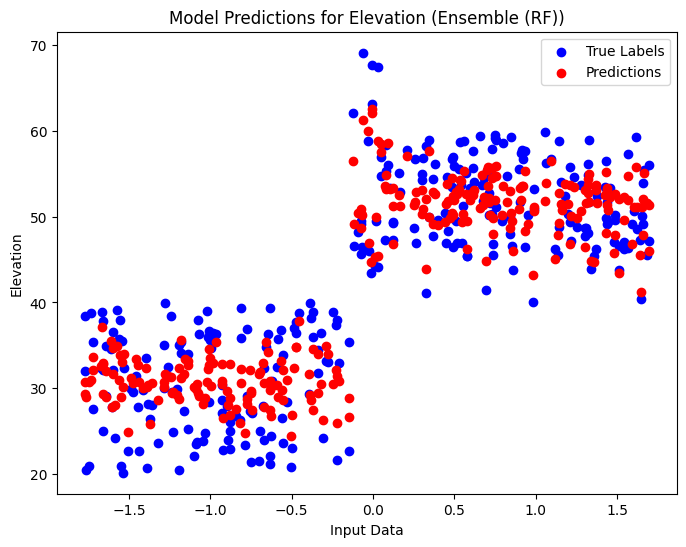

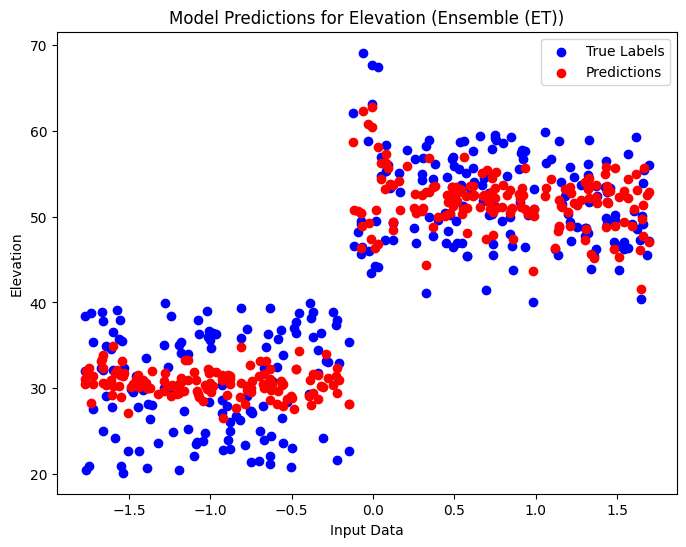

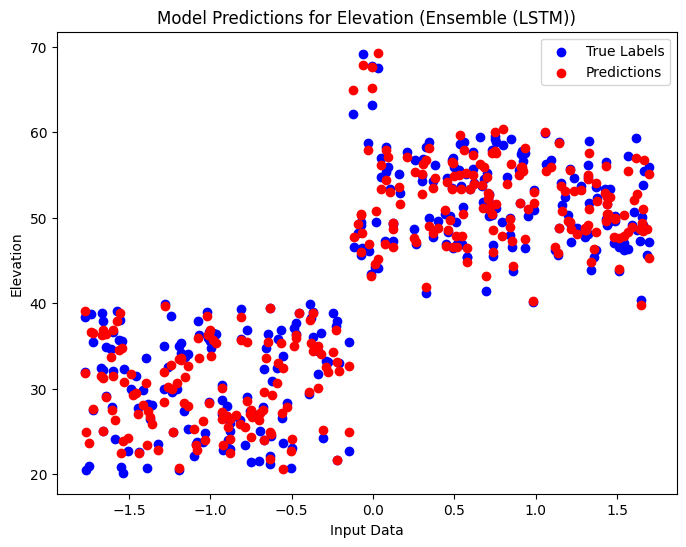

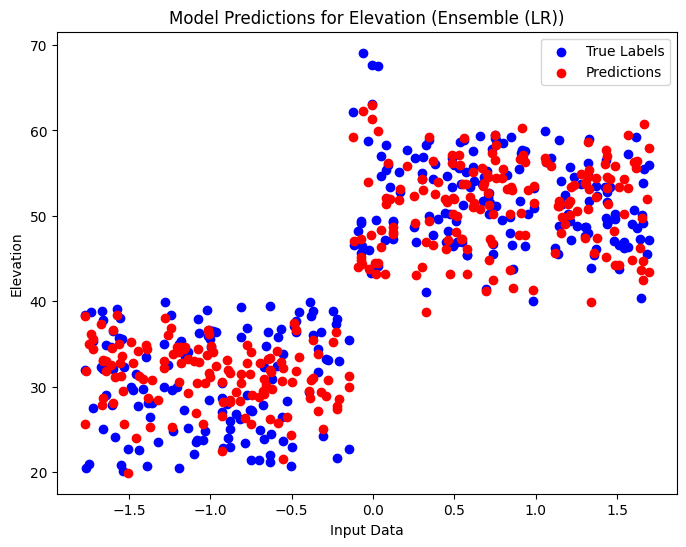

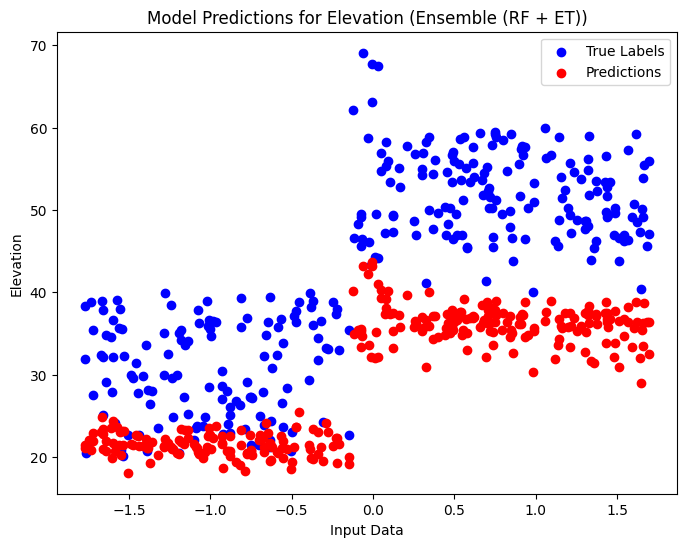

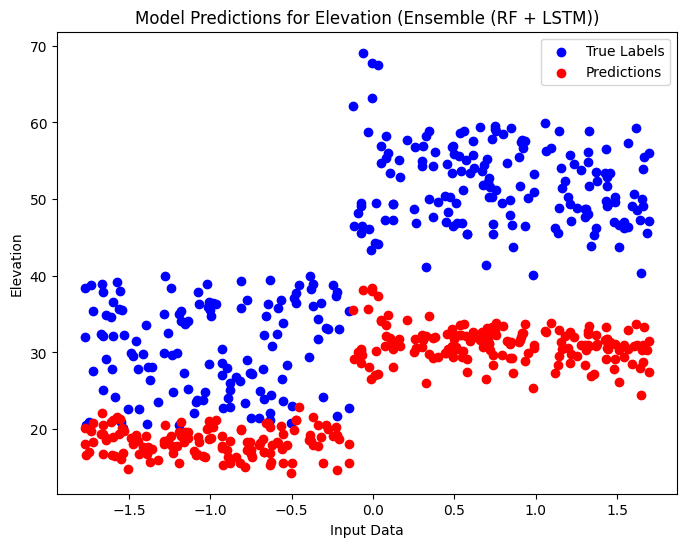

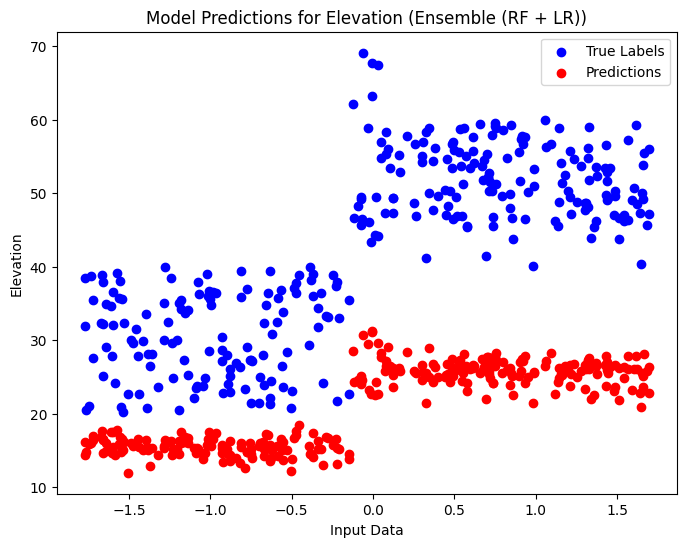

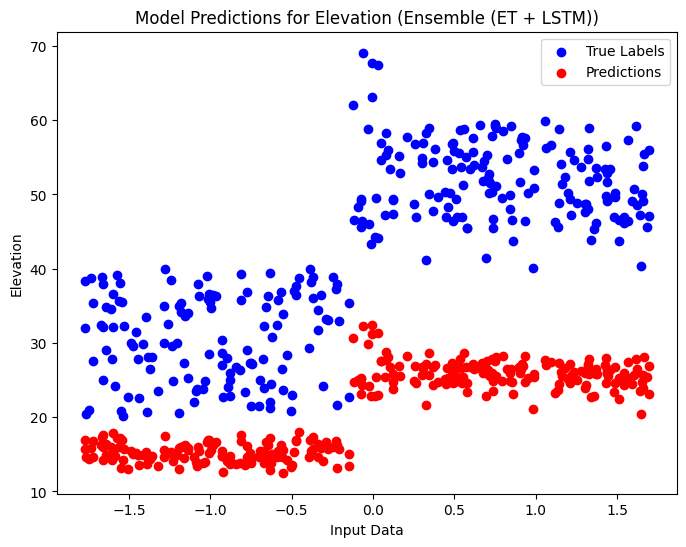

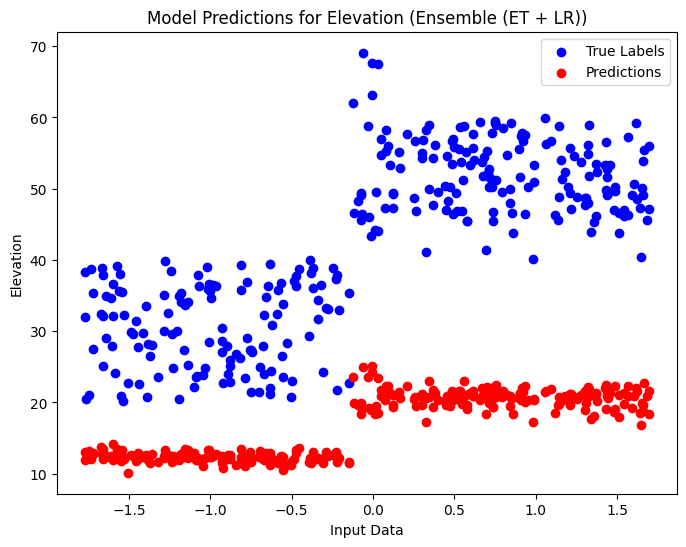

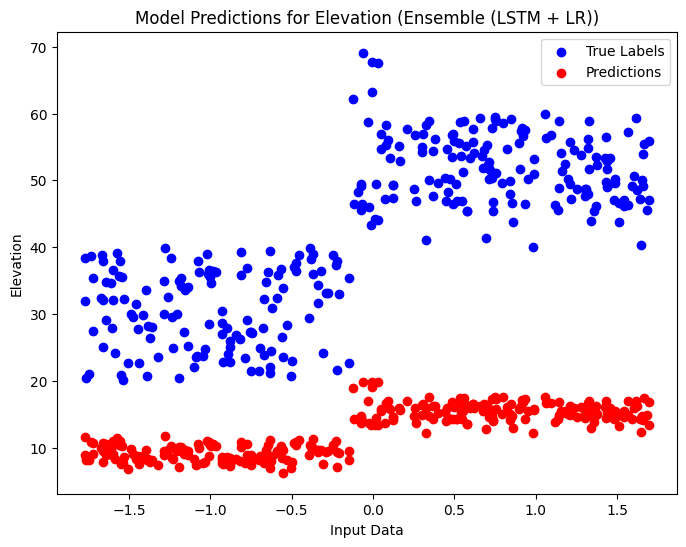

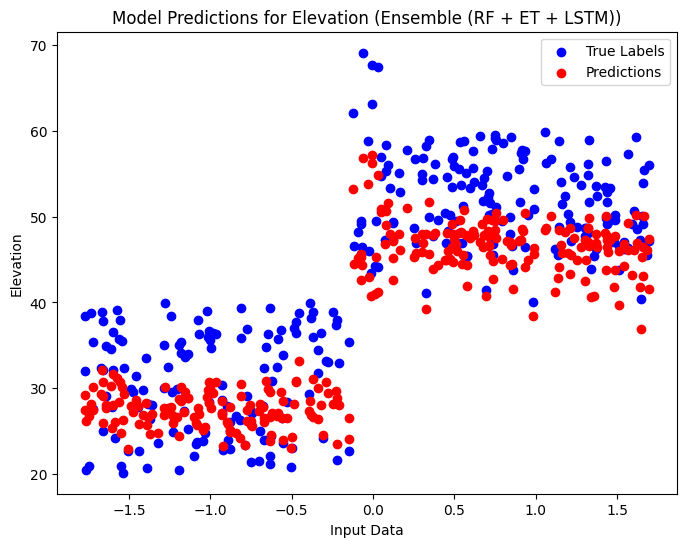

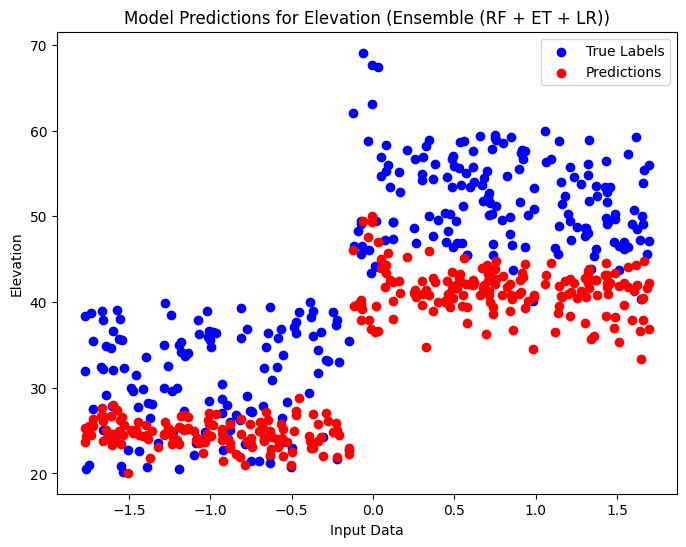

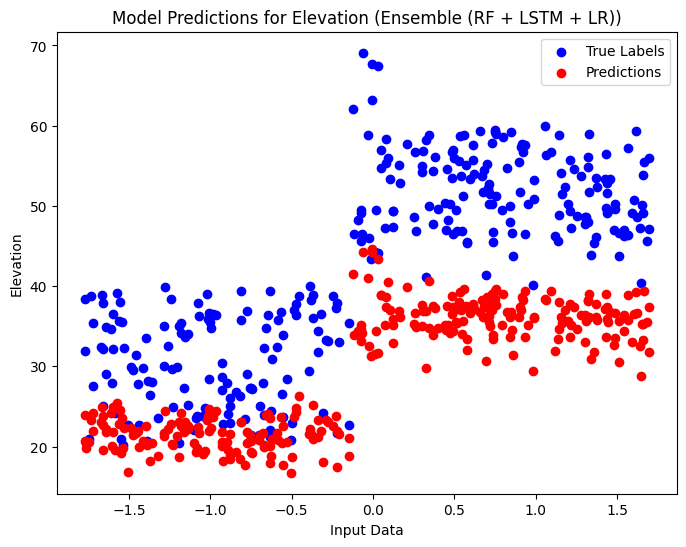

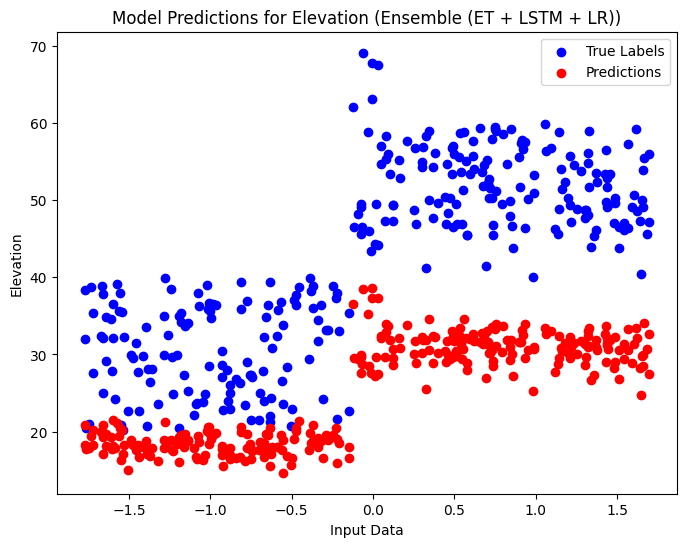

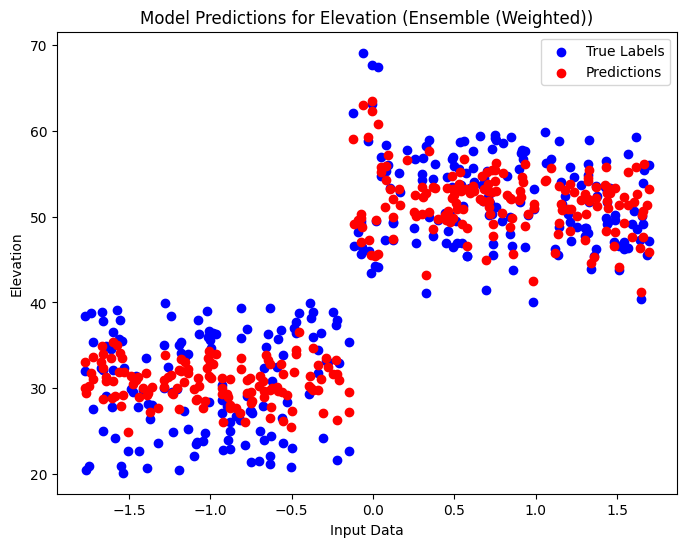

In [ ]:
# Importing necessary libraries
import matplotlib.pyplot as plt

# Defining the plotting function
def plot_model_predictions_elevation(x_data, y_data, ensemble_metrics, name):
    """
    Plot model predictions for elevation.

    Args:
        x_data:
        y_data:
        ensemble_metrics:
        name:
    """
    # Plotting logic here
    plt.figure(figsize=(8, 6))
    plt.scatter(x_data, y_data, color='blue', label='True Labels')
    plt.scatter(x_data, ensemble_metrics, color='red', label='Predictions')
    plt.title(f'Model Predictions for Elevation ({name})')
    plt.xlabel('Input Data')
    plt.ylabel('Elevation')
    plt.legend()
    plt.show()

# Defining ensemble_metrics dictionary
ensemble_metrics = {
    'Ensemble (RF)': rf_pred,
    'Ensemble (ET)': et_pred,
    'Ensemble (LSTM)': lstm_pred,
    'Ensemble (LR)': lr_pred,
    'Ensemble (RF + ET)': ensemble_pred_12,
    'Ensemble (RF + LSTM)': ensemble_pred_13,
    'Ensemble (RF + LR)': ensemble_pred_14,
    'Ensemble (ET + LSTM)': ensemble_pred_23,
    'Ensemble (ET + LR)': ensemble_pred_24,
    'Ensemble (LSTM + LR)': ensemble_pred_34,
    'Ensemble (RF + ET + LSTM)': ensemble_pred_123,
    'Ensemble (RF + ET + LR)': ensemble_pred_124,
    'Ensemble (RF + LSTM + LR)': ensemble_pred_134,
    'Ensemble (ET + LSTM + LR)': ensemble_pred_234,
    'Ensemble (Weighted)': ensemble_pred_weighted
}

# Plot for each combination of models
for name, ensemble_metrics in ensemble_metrics.items():
    plot_model_predictions_elevation(X_test[:, 2, 0], y_test, ensemble_metrics, name)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import random
import math
import csv

In [ ]:
# Define the number of entries in the dataset
num_entries = 2000

# Define the ranges for each feature
#distance_range = (10, 50)  # Km
speed_range = (20, 100)  # Kmph
acceleration_range = (1, 3)  # m/s²
elevation_change_range = (0, 100)  # meter
temperature_range = (15, 50)  # °C
weather_conditions = ['Sunny', 'Rainy', 'Cloudy']


hvac_usage = [0, 1]  # 0: No HVAC, 1: HVAC in use
battery_health_range = (80, 100)  # %
driving_modes = ['Eco', 'Normal', 'Sport']
SOC_range = (5,100) #%
Full_battery = 30.2 #kWh
# Data as per Tata Nexon
Area = 2.91 #m^2
Cd = 0.18 #Drag Coefficient
Rho = 1.2 #Air Density
mass=1295
g = 9.81
HVAC_load = 5
# Generate the dataset
dataset = []
for _ in range(num_entries):
    #distance = random.uniform(*distance_range)
    speed = random.uniform(*speed_range)
    acceleration = random.uniform(*acceleration_range)
    elevation_change = random.uniform(*elevation_change_range)
    temperature = None
    weather = random.choice(weather_conditions)
    hvac = random.choice(hvac_usage)
    battery_health = random.uniform(*battery_health_range)
    driving_mode = random.choice(driving_modes)
    SOC = random.uniform(*SOC_range)

    # Assign temperature based on weather conditions
    if weather == 'Sunny':
        temperature = random.uniform(25, 50)
    elif weather == 'Cloudy':
        temperature = random.uniform(20, 35)
    elif weather == 'Rainy':
        temperature = random.uniform(15, 25)

    # Calculate range (for demonstration, actual calculation may vary)
    # In practice, this should be calculated based on the actual formula or model
    h=math.sqrt((elevation_change*elevation_change)+(50*50))
    sinA = elevation_change/h
    Fd = 0.5*Rho*Cd*Area*speed*speed
    Fc= mass*g*sinA
    Pd = (Fd+Fc)*speed
    Eb = SOC*battery_health*Full_battery

    range_estimate = (Eb*3.6*speed)/Pd

    # Append the generated entry to the dataset
    dataset.append([ speed, acceleration, elevation_change, temperature, weather, hvac, battery_health, SOC, driving_mode, range_estimate])

# Export the dataset to a CSV file
csv_filename = "DataSet Weather.csv"
with open(csv_filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    # Write header
    writer.writerow(["Speed (Kmph)", "Acceleration (m/s²)", "Elevation Change (meter)", "Temperature (°C)", "Weather Conditions", "HVAC Usage", "Battery Health (%)", "State of Charge(%)", "Driving Mode", "Range (Km)"])
    # Write data rows
    writer.writerows(dataset)

print(f"Dataset exported to {csv_filename}")

Dataset exported to DataSet Weather.csv


In [ ]:
# Load dataset from CSV
dataset = pd.read_csv('/content/DataSet Weather.csv')

# Encode the categorical columns
label_encoder = LabelEncoder()
dataset['Weather Conditions'] = label_encoder.fit_transform(dataset['Weather Conditions'])
dataset['Driving Mode'] = label_encoder.fit_transform(dataset['Driving Mode'])

# Rename columns to match the specified column names
dataset.columns = ["Speed (Kmph)", "Acceleration (m/s²)", "Elevation Change (meter)", "Temperature (°C)", "Weather Conditions", "HVAC Usage", "Battery Health (%)", "State of Charge(%)", "Driving Mode", "Range (Km)"]

# Split data into features and target variable
X = dataset[['Speed (Kmph)', 'Acceleration (m/s²)', 'Elevation Change (meter)', 'Temperature (°C)', 'Weather Conditions', 'HVAC Usage', 'Battery Health (%)', 'State of Charge(%)', 'Driving Mode']].values
y = dataset['Range (Km)'].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape input data for LSTM
X_lstm = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y, test_size=0.3, random_state=42)

# Define models
rf_model = RandomForestRegressor()
et_model = ExtraTreesRegressor()
lstm_model = Sequential([
    LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(units=1)
])
lr_model = LinearRegression()

# Train models
rf_model.fit(X_train.reshape((X_train.shape[0], X_train.shape[1])), y_train)
et_model.fit(X_train.reshape((X_train.shape[0], X_train.shape[1])), y_train)
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=500, batch_size=32)
lr_model.fit(X_train.reshape((X_train.shape[0], X_train.shape[1])), y_train)

# Predictions
rf_pred = rf_model.predict(X_test.reshape((X_test.shape[0], X_test.shape[1])))
et_pred = et_model.predict(X_test.reshape((X_test.shape[0], X_test.shape[1])))
lstm_pred = lstm_model.predict(X_test).flatten()
lr_pred = lr_model.predict(X_test.reshape((X_test.shape[0], X_test.shape[1])))

# Define weights for each model (can be based on validation performance)
rf_weight = 0.4
et_weight = 0.3
lstm_weight = 0.2
lr_weight = 0.1

Epoch 1/500
44/44 [==============================] - 2s 6ms/step - loss: 17891.3672
Epoch 2/500
44/44 [==============================] - 0s 7ms/step - loss: 12032.4805
Epoch 3/500
44/44 [==============================] - 0s 6ms/step - loss: 11296.7266
Epoch 4/500
44/44 [==============================] - 0s 8ms/step - loss: 10895.8369
Epoch 5/500
44/44 [==============================] - 0s 10ms/step - loss: 10986.2217
Epoch 6/500
44/44 [==============================] - 1s 11ms/step - loss: 10941.2461
Epoch 7/500
44/44 [==============================] - 0s 11ms/step - loss: 10575.1738
Epoch 8/500
44/44 [==============================] - 1s 12ms/step - loss: 10960.8857
Epoch 9/500
44/44 [==============================] - 0s 11ms/step - loss: 10564.5996
Epoch 10/500
44/44 [==============================] - 1s 12ms/step - loss: 10709.3135
Epoch 11/500
44/44 [==============================] - 0s 11ms/step - loss: 10548.6514
Epoch 12/500
44/44 [==============================] - 0s 11ms/step 

In [ ]:
def evaluate_ensemble_prediction(ensemble_name, ensemble_pred, y_test):
    return {
        "Name": ensemble_name,
        "MAE": mean_absolute_error(y_test, ensemble_pred),
        "MSE": mean_squared_error(y_test, ensemble_pred),
        "R^2": r2_score(y_test, ensemble_pred)
    }

# Initialize ensemble_metrics dictionary
ensemble_metrics = {}

# Combine predictions from all models using weighted averaging
ensemble_pred_1 = (rf_weight * rf_pred)
ensemble_pred_2 = (et_weight * et_pred)
ensemble_pred_3 = (lstm_weight * lstm_pred)
ensemble_pred_4 = (lr_weight * lr_pred)

# Evaluate performance of each one-model ensemble
ensemble_metrics.update({
    'Ensemble (RF)': evaluate_ensemble_prediction("Ensemble (RF)", ensemble_pred_1, y_test),
    'Ensemble (ET)': evaluate_ensemble_prediction("Ensemble (ET)", ensemble_pred_2, y_test),
    'Ensemble (LSTM)': evaluate_ensemble_prediction("Ensemble (LSTM)", ensemble_pred_3, y_test),
    'Ensemble (LR)': evaluate_ensemble_prediction("Ensemble (LR)", ensemble_pred_4, y_test)
})

# Combine predictions from all models using weighted averaging
ensemble_pred_12 = (rf_weight * rf_pred + et_weight * et_pred)
ensemble_pred_13 = (rf_weight * rf_pred + lstm_weight * lstm_pred)
ensemble_pred_14 = (rf_weight * rf_pred + lr_weight * lr_pred)
ensemble_pred_23 = (et_weight * et_pred + lstm_weight * lstm_pred)
ensemble_pred_24 = (et_weight * et_pred + lr_weight * lr_pred)
ensemble_pred_34 = (lstm_weight * lstm_pred + lr_weight * lr_pred)

# Evaluate performance of each two-model ensemble
ensemble_metrics.update({
    'Ensemble (RF + ET)': evaluate_ensemble_prediction("Ensemble (RF + ET)", ensemble_pred_12, y_test),
    'Ensemble (RF + LSTM)': evaluate_ensemble_prediction("Ensemble (RF + LSTM)", ensemble_pred_13, y_test),
    'Ensemble (RF + LR)': evaluate_ensemble_prediction("Ensemble (RF + LR)", ensemble_pred_14, y_test),
    'Ensemble (ET + LSTM)': evaluate_ensemble_prediction("Ensemble (ET + LSTM)", ensemble_pred_23, y_test),
    'Ensemble (ET + LR)': evaluate_ensemble_prediction("Ensemble (ET + LR)", ensemble_pred_24, y_test),
    'Ensemble (LSTM + LR)': evaluate_ensemble_prediction("Ensemble (LSTM + LR)", ensemble_pred_34, y_test)
})

# Combine predictions from all models using weighted averaging
ensemble_pred_123 = (rf_weight * rf_pred + et_weight * et_pred + lstm_weight * lstm_pred)
ensemble_pred_124 = (rf_weight * rf_pred + et_weight * et_pred + lr_weight * lr_pred)
ensemble_pred_134 = (rf_weight * rf_pred + lstm_weight * lstm_pred + lr_weight * lr_pred)
ensemble_pred_234 = (et_weight * et_pred + lstm_weight * lstm_pred + lr_weight * lr_pred)

# Evaluate performance of each three-model ensemble
ensemble_metrics.update({
    'Ensemble (RF + ET + LSTM)': evaluate_ensemble_prediction("Ensemble (RF + ET + LSTM)", ensemble_pred_123, y_test),
    'Ensemble (RF + ET + LR)': evaluate_ensemble_prediction("Ensemble (RF + ET + LR)", ensemble_pred_124, y_test),
    'Ensemble (RF + LSTM + LR)': evaluate_ensemble_prediction("Ensemble (RF + LSTM + LR)", ensemble_pred_134, y_test),
    'Ensemble (ET + LSTM + LR)': evaluate_ensemble_prediction("Ensemble (ET + LSTM + LR)", ensemble_pred_234, y_test)
})

# Combine predictions from all models using weighted averaging
ensemble_pred_weighted = (rf_weight * rf_pred + et_weight * et_pred +
                          lstm_weight * lstm_pred + lr_weight * lr_pred)

# Evaluate performance of the weighted ensemble
ensemble_metrics['Ensemble (Weighted)'] = evaluate_ensemble_prediction("Ensemble (Weighted)", ensemble_pred_weighted, y_test)

# Print ensemble metrics
for name, metrics in ensemble_metrics.items():
    print(f"{metrics['Name']} Metrics:")
    print(f"MAE: {metrics['MAE']}")
    print(f"MSE: {metrics['MSE']}")
    print(f"R^2: {metrics['R^2']}")
    print()

Ensemble (RF) Metrics:
MAE: 51.37436074286862
MSE: 11512.613700332297
R^2: 0.3013769693642018

Ensemble (ET) Metrics:
MAE: 59.43491544625172
MSE: 13651.292086532398
R^2: 0.1715949741879661

Ensemble (LSTM) Metrics:
MAE: 67.75138471446111
MSE: 17070.702425585336
R^2: -0.035906022218053835

Ensemble (LR) Metrics:
MAE: 76.41994582378898
MSE: 21386.484085998123
R^2: -0.2978017603746246

Ensemble (RF + ET) Metrics:
MAE: 26.85088340461409
MSE: 5595.888439364427
R^2: 0.6604231982094768

Ensemble (RF + LSTM) Metrics:
MAE: 34.890688484393785
MSE: 7528.3075242152
R^2: 0.543157691639241

Ensemble (RF + LR) Metrics:
MAE: 43.47260489704371
MSE: 10179.576970109974
R^2: 0.3822699954534794

Ensemble (ET + LSTM) Metrics:
MAE: 42.83082731525095
MSE: 9089.153645878007
R^2: 0.4484404470364166

Ensemble (ET + LR) Metrics:
MAE: 51.45830074576338
MSE: 12104.542291784053
R^2: 0.26545680759693346

Ensemble (LSTM + LR) Metrics:
MAE: 59.774927223650664
MSE: 15296.913891252882
R^2: 0.07173326403078495

Ensemble (

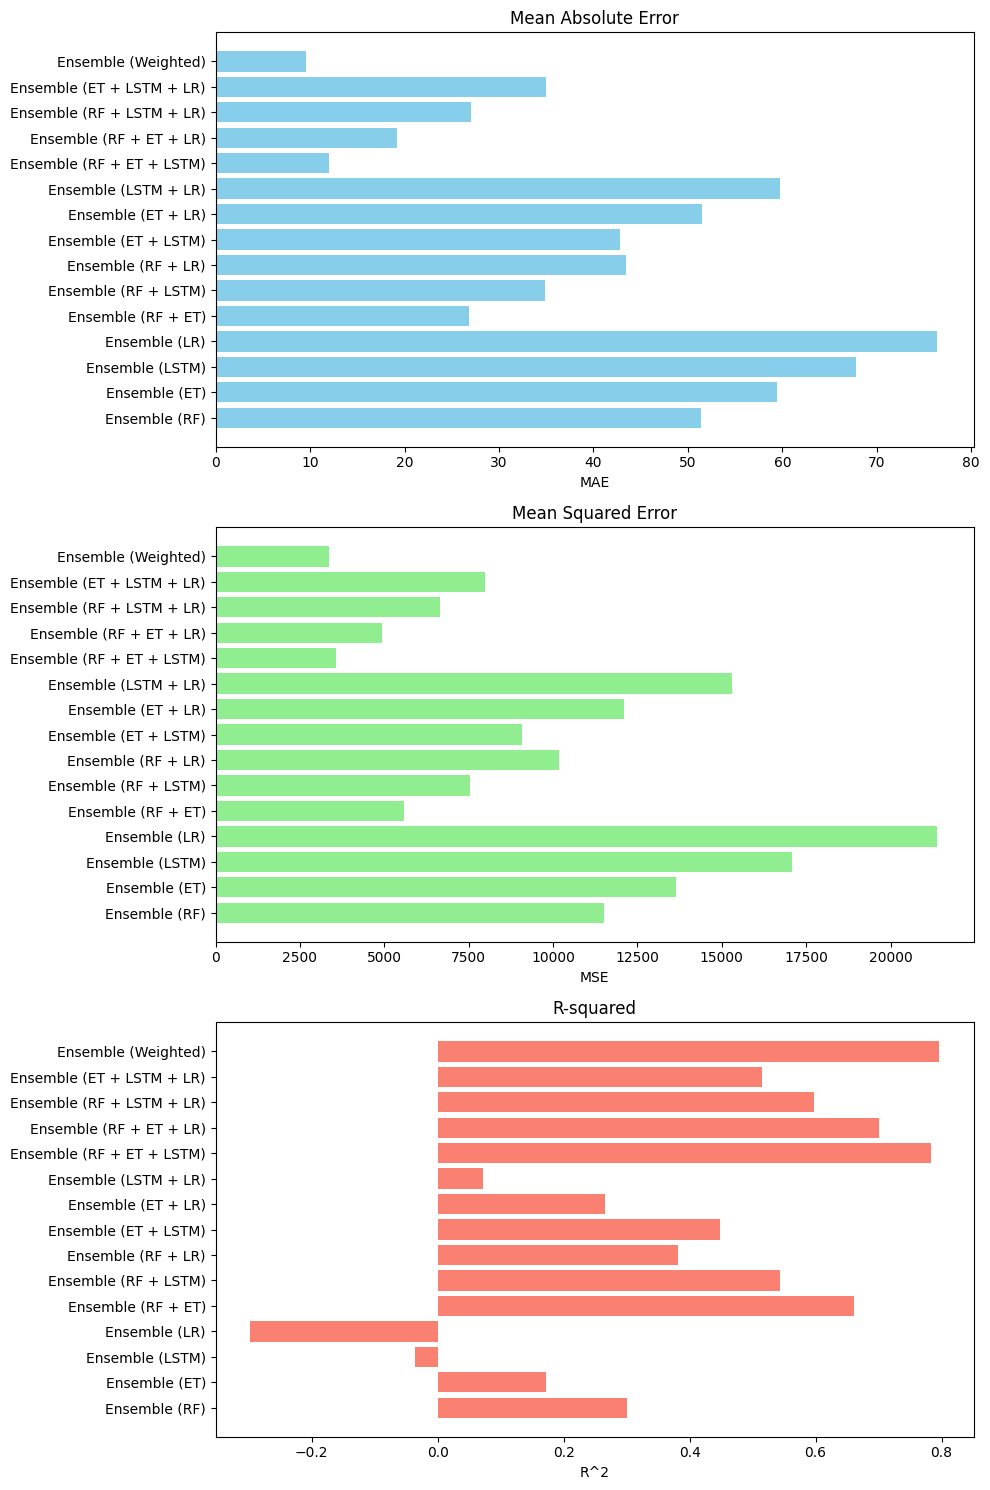

In [ ]:
import matplotlib.pyplot as plt

# Extract metrics for plotting
ensemble_names = [metrics['Name'] for metrics in ensemble_metrics.values()]
mae_values = [metrics['MAE'] for metrics in ensemble_metrics.values()]
mse_values = [metrics['MSE'] for metrics in ensemble_metrics.values()]
r2_values = [metrics['R^2'] for metrics in ensemble_metrics.values()]

# Plotting MAE, MSE, and R^2
fig, axs = plt.subplots(3, figsize=(10, 15))

axs[0].barh(ensemble_names, mae_values, color='skyblue')
axs[0].set_xlabel('MAE')
axs[0].set_title('Mean Absolute Error')

axs[1].barh(ensemble_names, mse_values, color='lightgreen')
axs[1].set_xlabel('MSE')
axs[1].set_title('Mean Squared Error')

axs[2].barh(ensemble_names, r2_values, color='salmon')
axs[2].set_xlabel('R^2')
axs[2].set_title('R-squared')

plt.tight_layout()
plt.show()

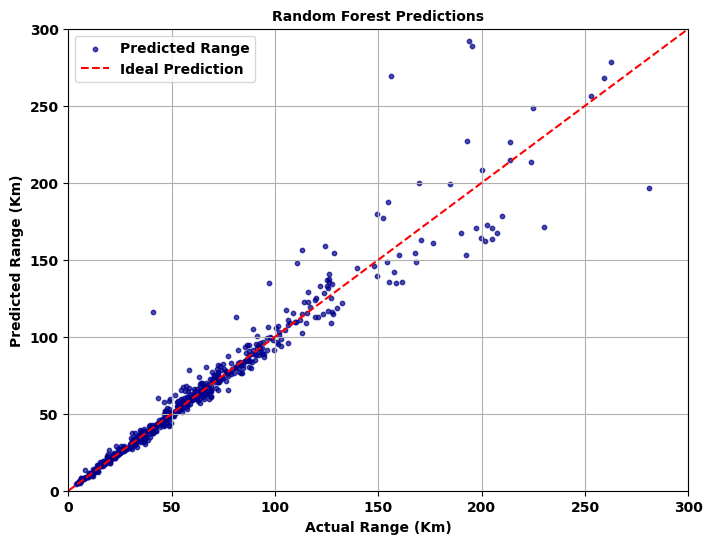

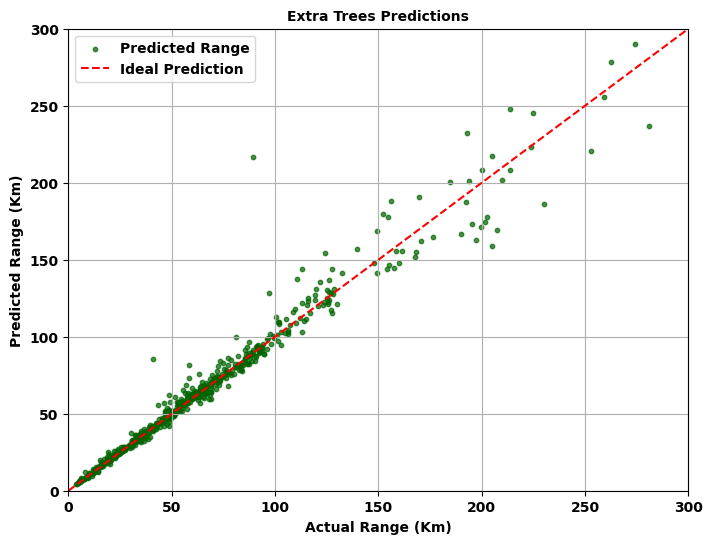

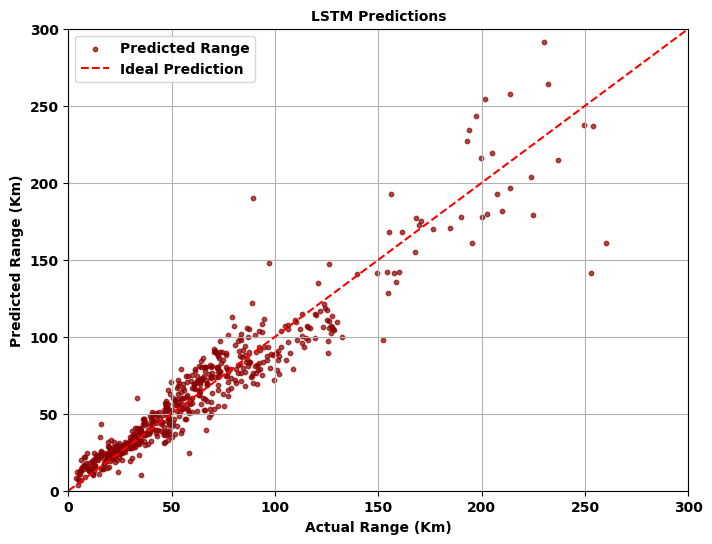

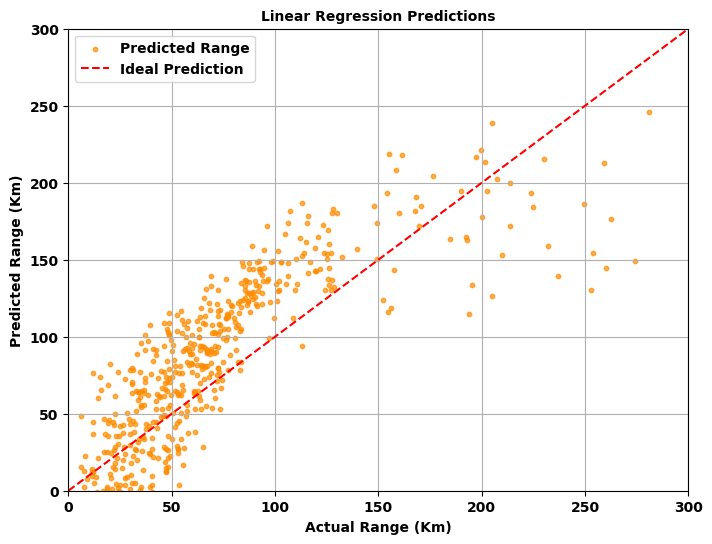

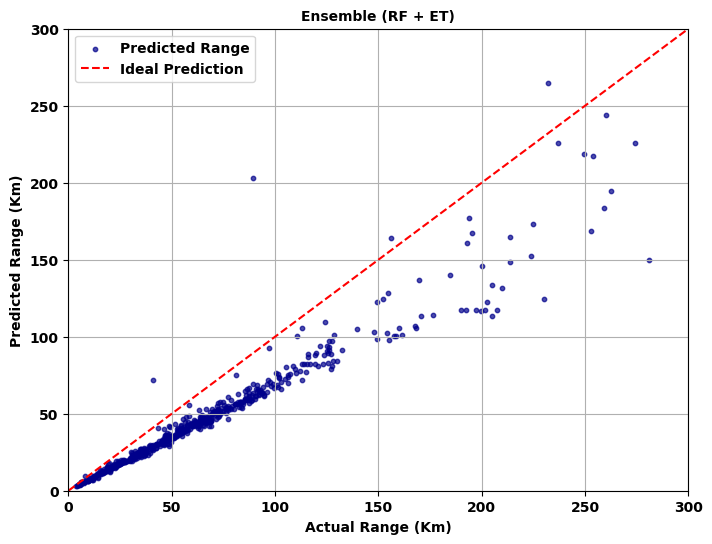

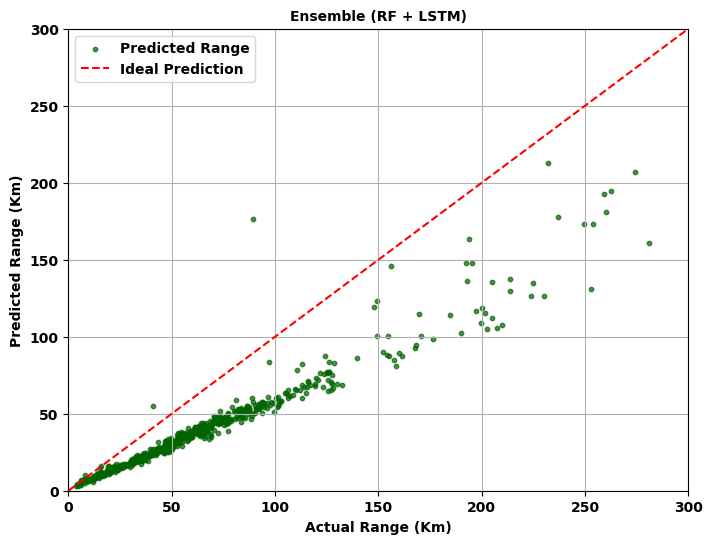

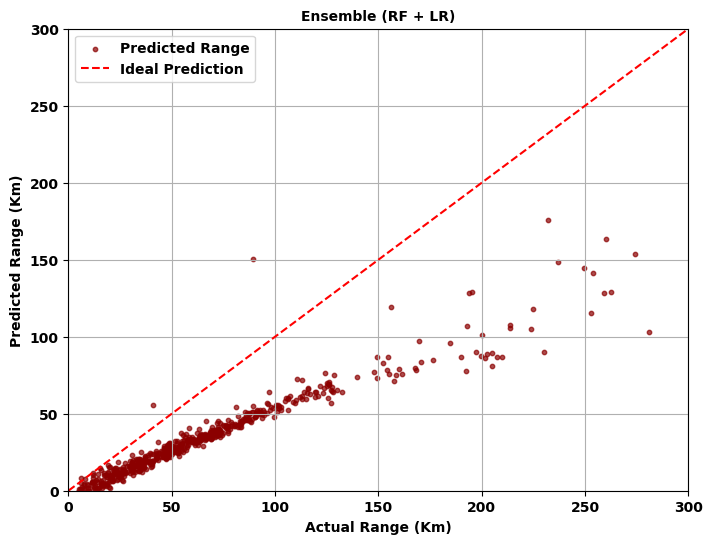

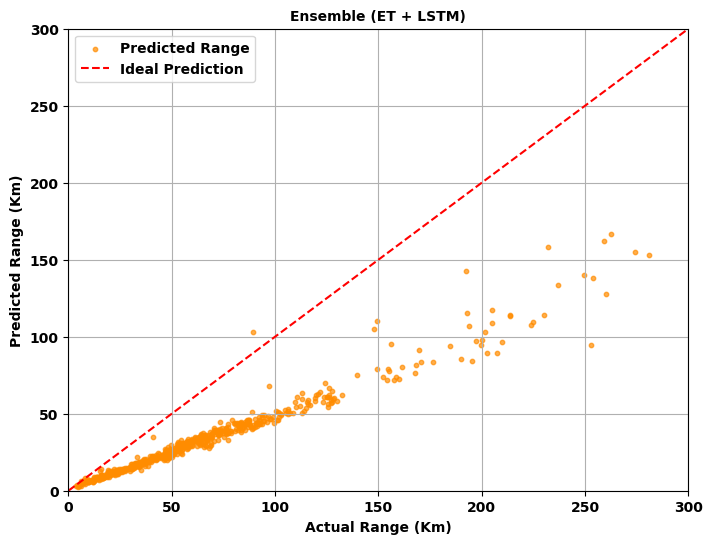

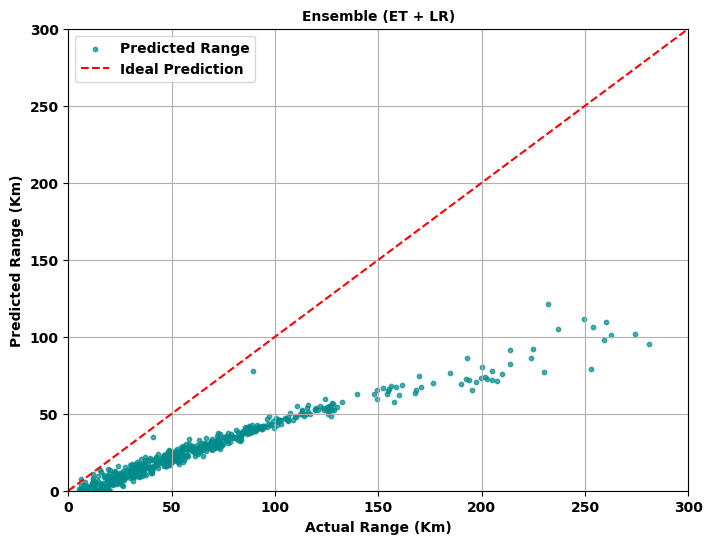

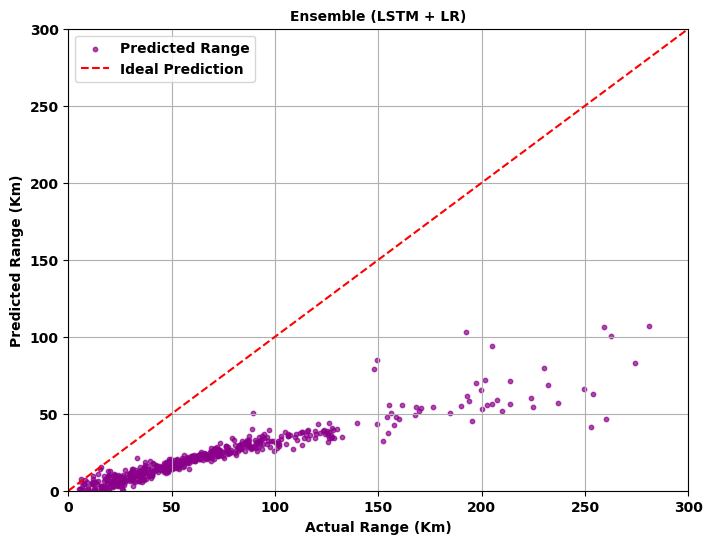

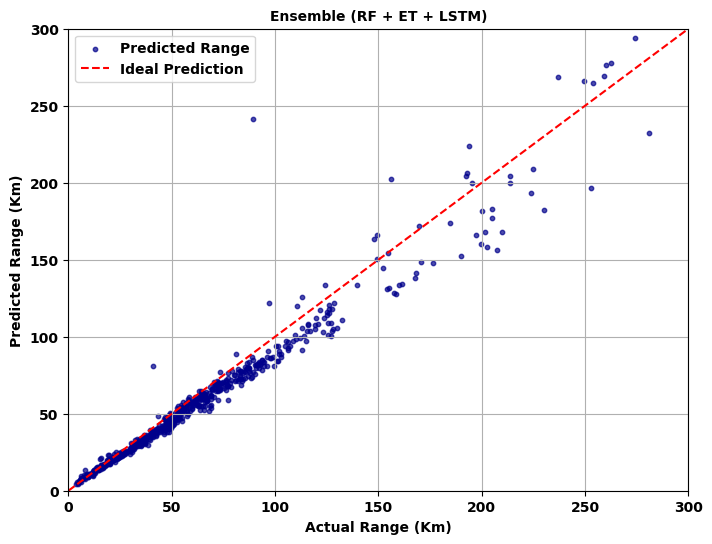

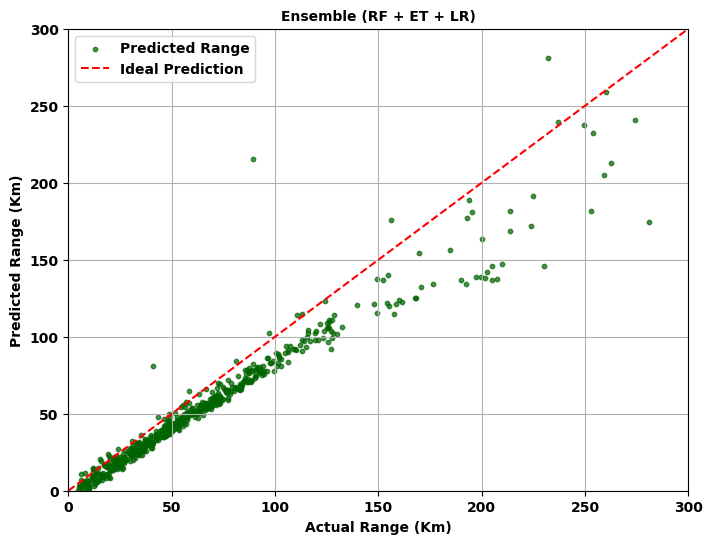

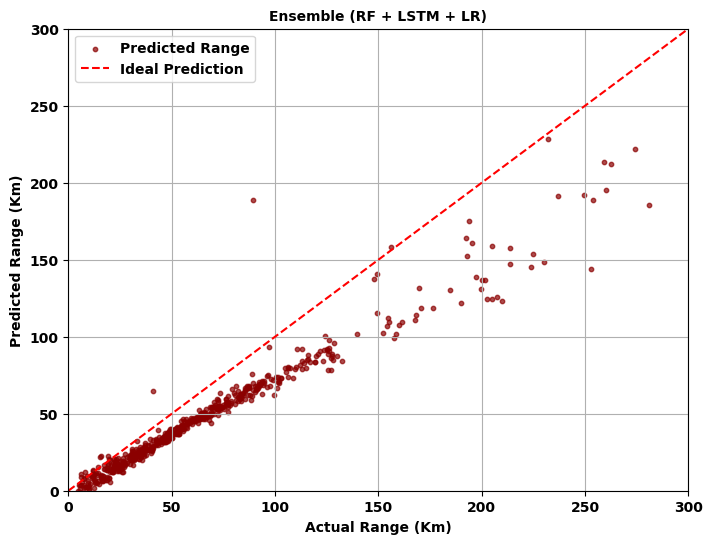

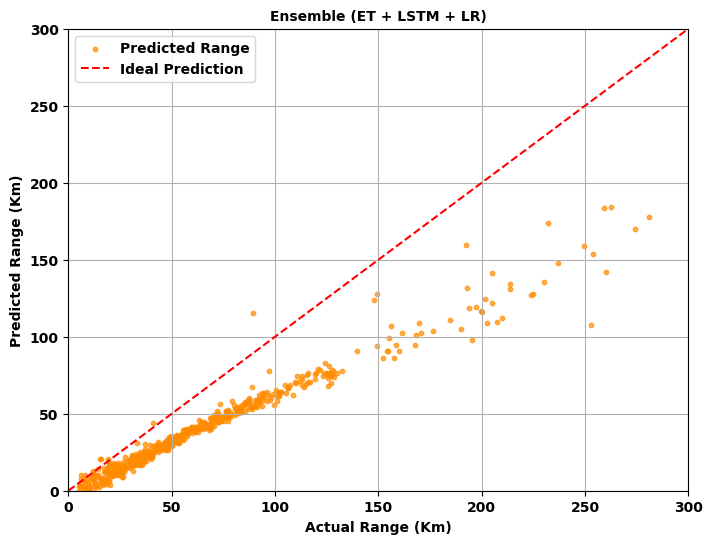

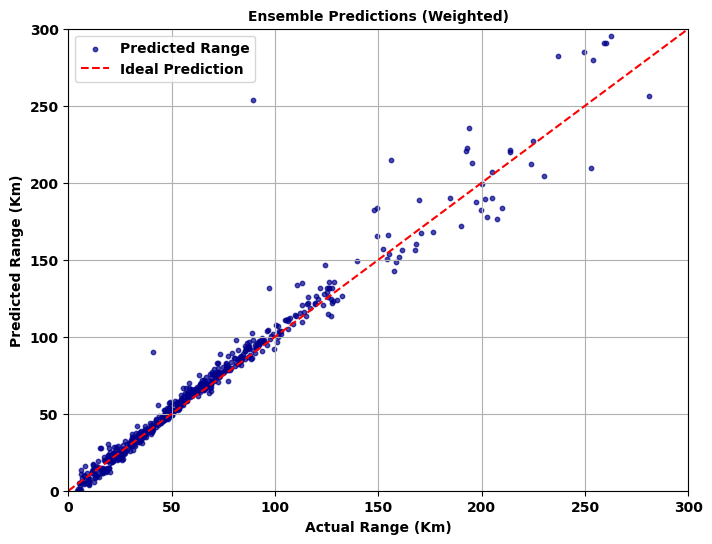

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# Define a function to plot results with different colors and smaller points
def plot_results(y_true, y_pred, title, color='blue'):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, color=color, label='Predicted Range', alpha=0.7, s=10)  # Use alpha to control transparency and s to control point size
    plt.plot([0, 300], [0, 300], color='red', linestyle='--', label='Ideal Prediction')

    # Set font properties to bold
    font_bold = FontProperties(weight='bold')

    # Set bold axes labels and their readings
    plt.xlabel('Actual Range (Km)', fontproperties=font_bold)
    plt.ylabel('Predicted Range (Km)', fontproperties=font_bold)
    plt.title(title, fontproperties=font_bold)

    # Set bold legend
    plt.legend(prop=font_bold)

    # Set bold ticks
    plt.xticks(fontproperties=font_bold)
    plt.yticks(fontproperties=font_bold)

    plt.xlim(0, 300)
    plt.ylim(0, 300)
    plt.grid(True)
    plt.show()

# Plot individual model results with dark colors and smaller points
plot_results(y_test, rf_pred, 'Random Forest Predictions', color='darkblue')
plot_results(y_test, et_pred, 'Extra Trees Predictions', color='darkgreen')
plot_results(y_test, lstm_pred, 'LSTM Predictions', color='darkred')
plot_results(y_test, lr_pred, 'Linear Regression Predictions', color='darkorange')

# Plot ensemble results with dark colors and smaller points
plot_results(y_test, ensemble_pred_12, 'Ensemble (RF + ET)', color='darkblue')
plot_results(y_test, ensemble_pred_13, 'Ensemble (RF + LSTM)', color='darkgreen')
plot_results(y_test, ensemble_pred_14, 'Ensemble (RF + LR)', color='darkred')
plot_results(y_test, ensemble_pred_23, 'Ensemble (ET + LSTM)', color='darkorange')
plot_results(y_test, ensemble_pred_24, 'Ensemble (ET + LR)', color='darkcyan')
plot_results(y_test, ensemble_pred_34, 'Ensemble (LSTM + LR)', color='darkmagenta')

plot_results(y_test, ensemble_pred_123, 'Ensemble (RF + ET + LSTM)', color='darkblue')
plot_results(y_test, ensemble_pred_124, 'Ensemble (RF + ET + LR)', color='darkgreen')
plot_results(y_test, ensemble_pred_134, 'Ensemble (RF + LSTM + LR)', color='darkred')
plot_results(y_test, ensemble_pred_234, 'Ensemble (ET + LSTM + LR)', color='darkorange')

plot_results(y_test, ensemble_pred_weighted, 'Ensemble Predictions (Weighted)', color='darkblue')

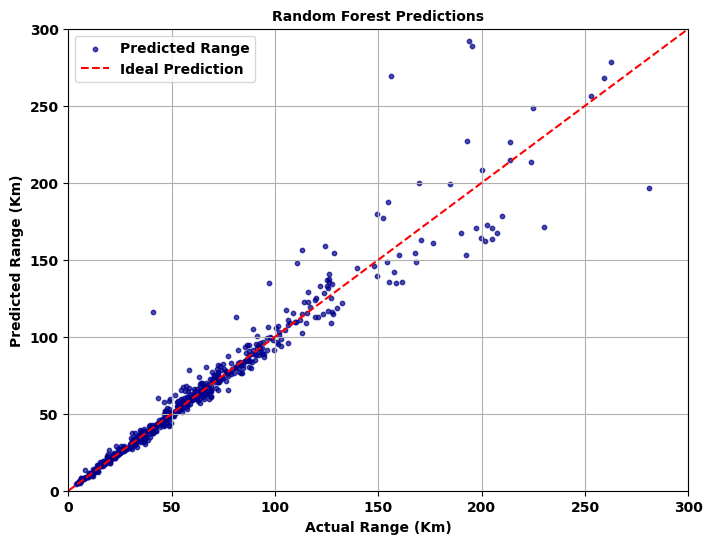

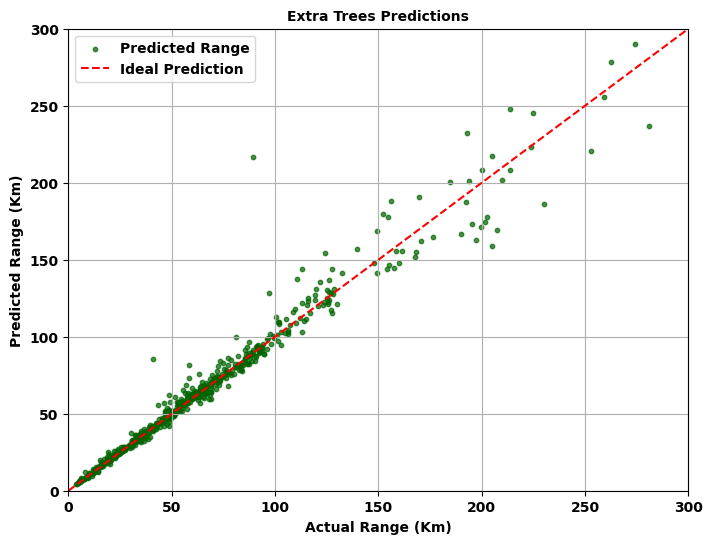

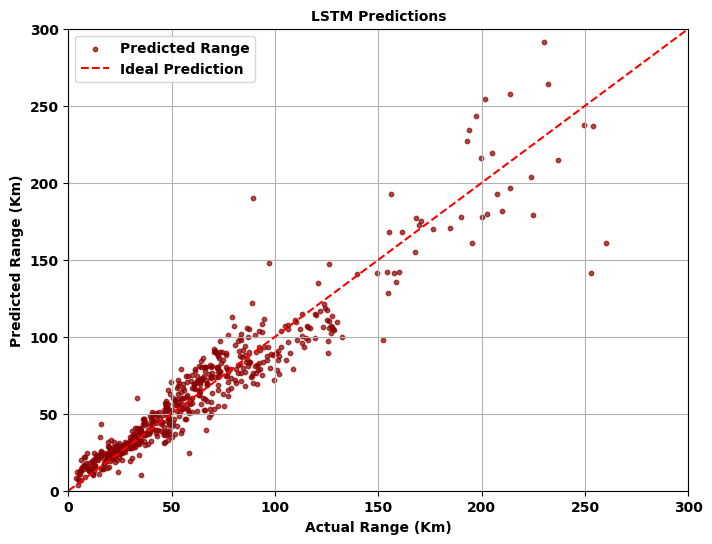

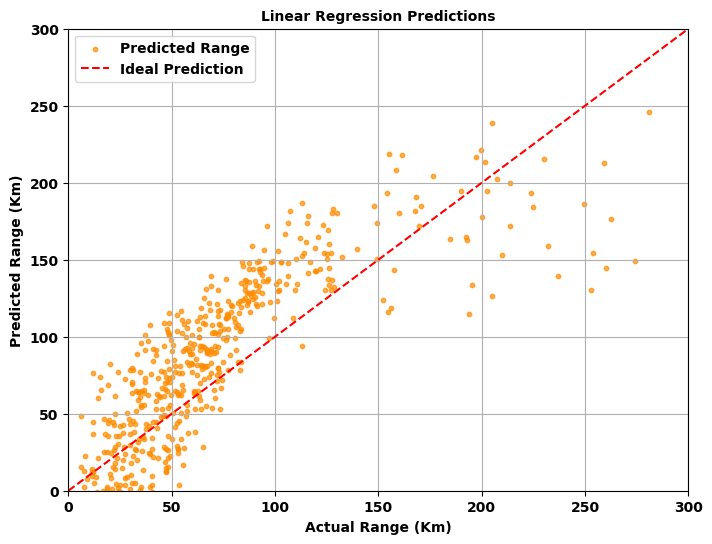

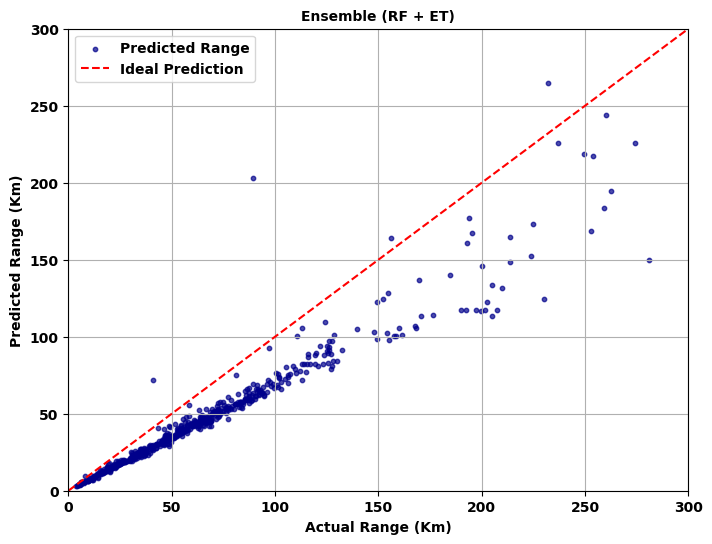

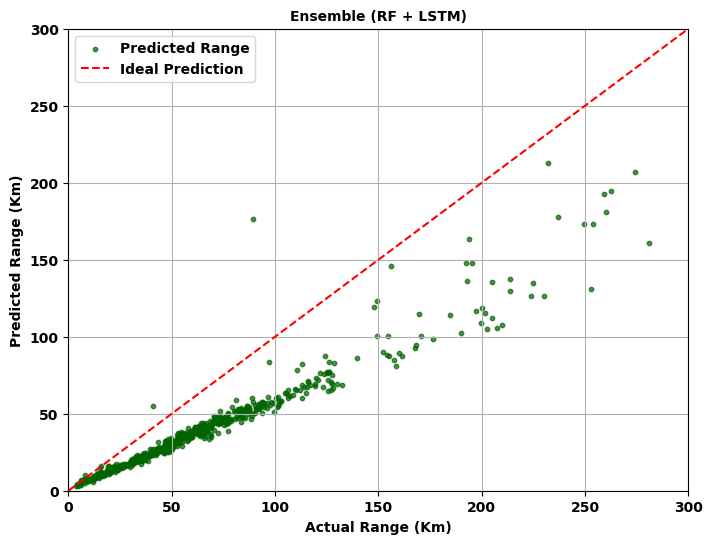

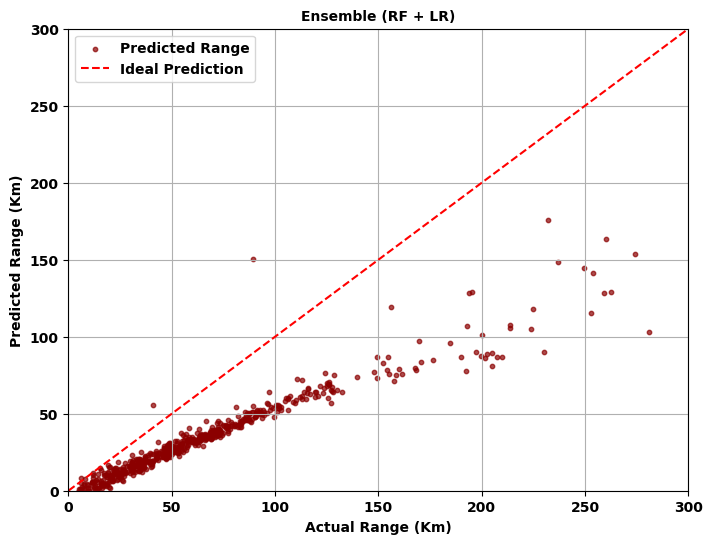

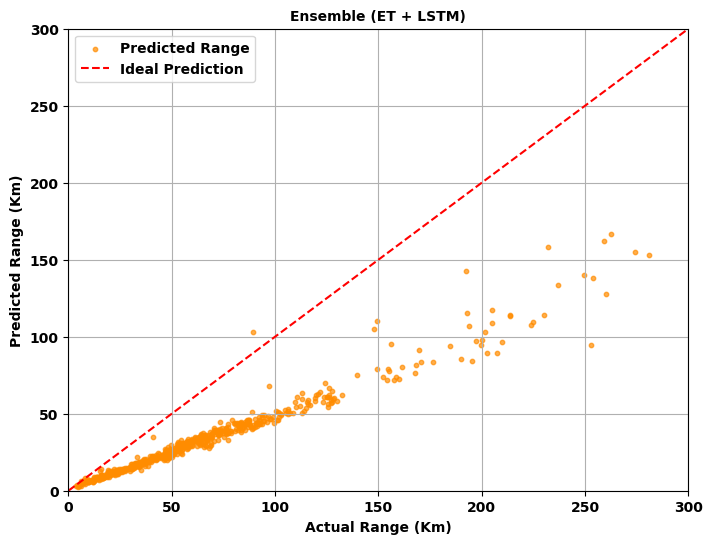

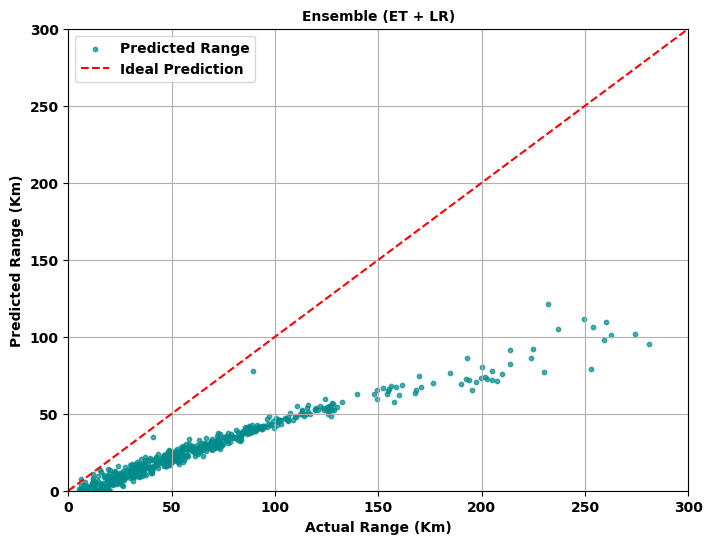

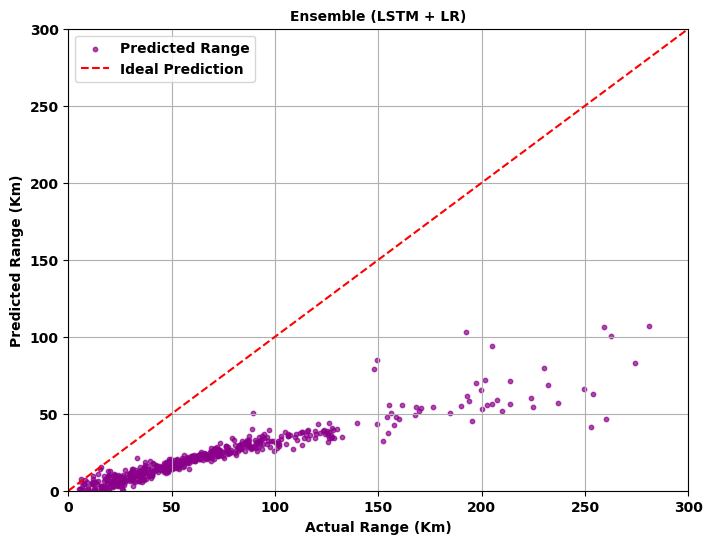

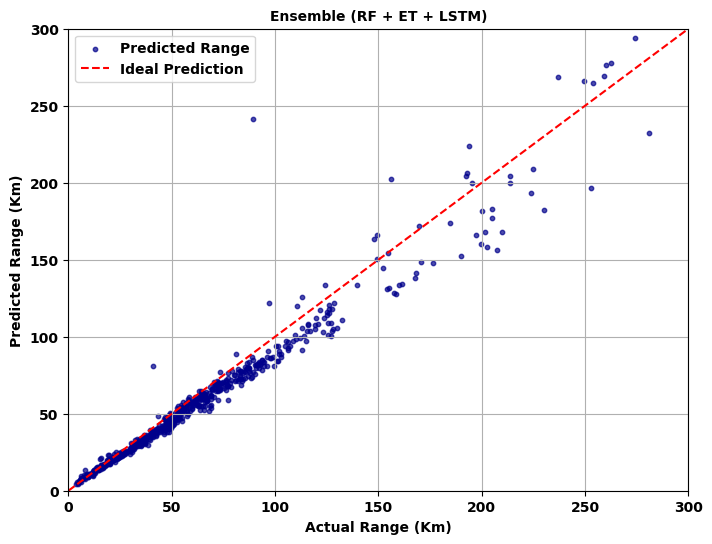

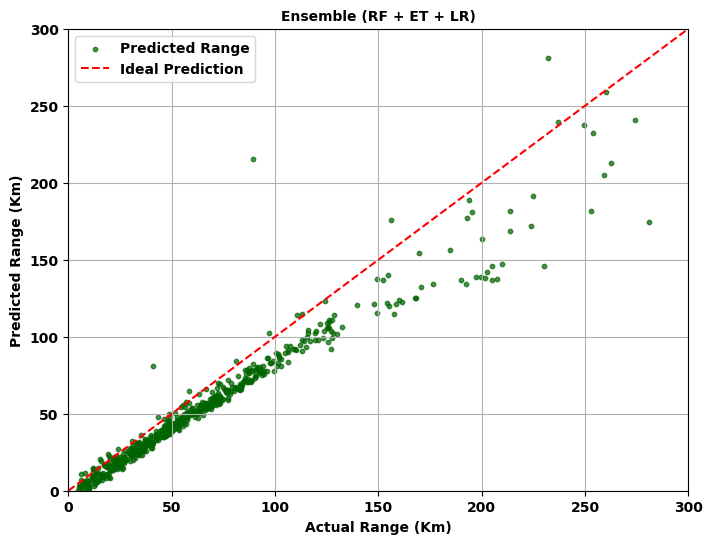

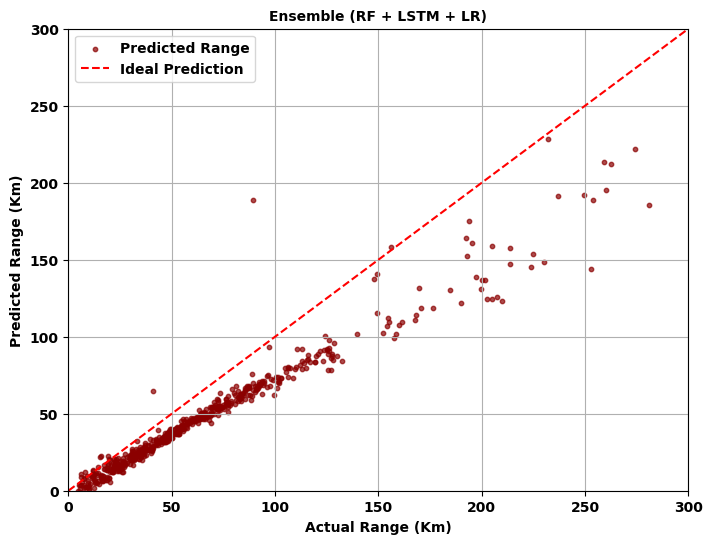

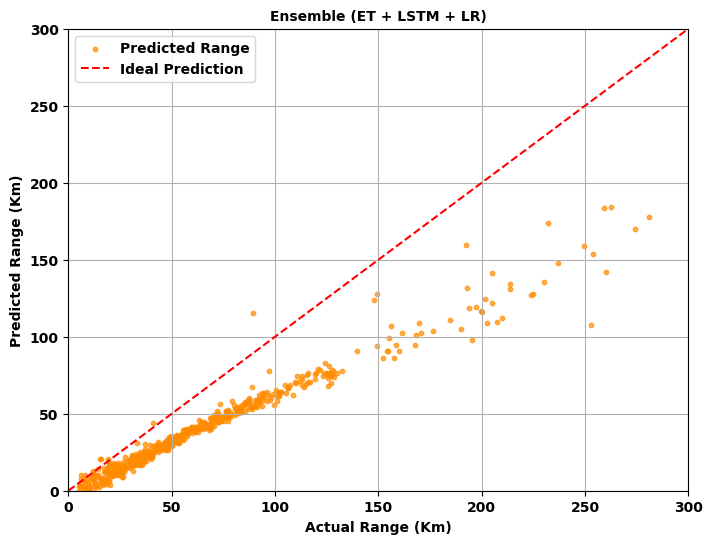

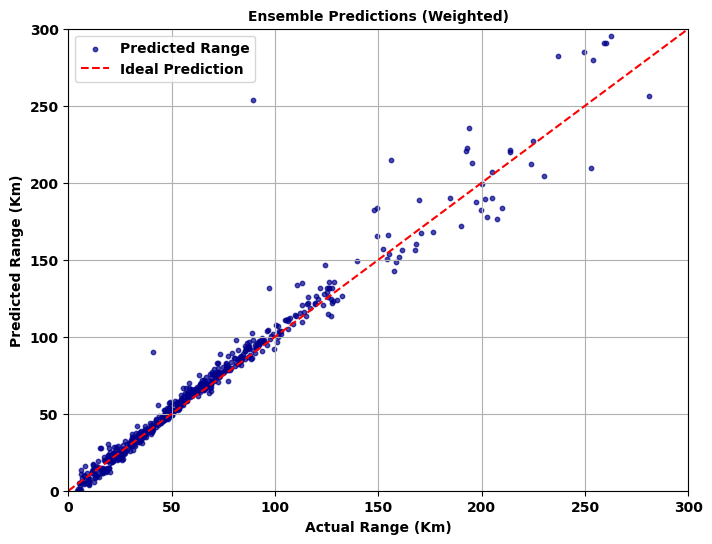

In [ ]:
# To save in pdf format

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# Define a function to plot results with different colors and smaller points
def plot_results(y_true, y_pred, title, color='blue', save_as_pdf=False):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, color=color, label='Predicted Range', alpha=0.7, s=10)  # Use alpha to control transparency and s to control point size
    plt.plot([0, 300], [0, 300], color='red', linestyle='--', label='Ideal Prediction')

    # Set font properties to bold
    font_bold = FontProperties(weight='bold')

    # Set bold axes labels and their readings
    plt.xlabel('Actual Range (Km)', fontproperties=font_bold)
    plt.ylabel('Predicted Range (Km)', fontproperties=font_bold)
    plt.title(title, fontproperties=font_bold)

    # Set bold legend
    plt.legend(prop=font_bold)

    # Set bold ticks
    plt.xticks(fontproperties=font_bold)
    plt.yticks(fontproperties=font_bold)

    plt.xlim(0, 300)
    plt.ylim(0, 300)
    plt.grid(True)

    if save_as_pdf:
        plt.savefig(f"{title}.pdf", format='pdf', bbox_inches='tight')  # Save plot as PDF
    else:
        plt.show()

# Plot individual model results with dark colors and smaller points
plot_results(y_test, rf_pred, 'Random Forest Predictions', color='darkblue', save_as_pdf=True)
plot_results(y_test, et_pred, 'Extra Trees Predictions', color='darkgreen', save_as_pdf=True)
plot_results(y_test, lstm_pred, 'LSTM Predictions', color='darkred', save_as_pdf=True)
plot_results(y_test, lr_pred, 'Linear Regression Predictions', color='darkorange', save_as_pdf=True)

# Plot ensemble results with dark colors and smaller points
plot_results(y_test, ensemble_pred_12, 'Ensemble (RF + ET)', color='darkblue', save_as_pdf=True)
plot_results(y_test, ensemble_pred_13, 'Ensemble (RF + LSTM)', color='darkgreen', save_as_pdf=True)
plot_results(y_test, ensemble_pred_14, 'Ensemble (RF + LR)', color='darkred', save_as_pdf=True)
plot_results(y_test, ensemble_pred_23, 'Ensemble (ET + LSTM)', color='darkorange', save_as_pdf=True)
plot_results(y_test, ensemble_pred_24, 'Ensemble (ET + LR)', color='darkcyan', save_as_pdf=True)
plot_results(y_test, ensemble_pred_34, 'Ensemble (LSTM + LR)', color='darkmagenta', save_as_pdf=True)

plot_results(y_test, ensemble_pred_123, 'Ensemble (RF + ET + LSTM)', color='darkblue', save_as_pdf=True)
plot_results(y_test, ensemble_pred_124, 'Ensemble (RF + ET + LR)', color='darkgreen', save_as_pdf=True)
plot_results(y_test, ensemble_pred_134, 'Ensemble (RF + LSTM + LR)', color='darkred', save_as_pdf=True)
plot_results(y_test, ensemble_pred_234, 'Ensemble (ET + LSTM + LR)', color='darkorange', save_as_pdf=True)

plot_results(y_test, ensemble_pred_weighted, 'Ensemble Predictions (Weighted)', color='darkblue', save_as_pdf=True)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset from CSV
dataset = pd.read_csv('/content/DataSet Weather.csv')
# Encode the categorical columns
label_encoder = LabelEncoder()
dataset['Weather Conditions'] = label_encoder.fit_transform(dataset['Weather Conditions'])
dataset['Driving Mode'] = label_encoder.fit_transform(dataset['Driving Mode'])


# Feature selection
X = dataset[['Speed (Kmph)', 'Acceleration (m/s²)', 'Elevation Change (meter)', 'Temperature (°C)', 'Weather Conditions', 'HVAC Usage', 'Battery Health (%)', 'State of Charge(%)', 'Driving Mode']]
y_velocity = dataset['Speed (Kmph)']
y_acceleration = dataset['Acceleration (m/s²)']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into train and test sets for velocity
X_train_v, X_test_v, y_train_v, y_test_v = train_test_split(X_scaled, y_velocity, test_size=0.3, random_state=42)

# Train velocity prediction model (Random Forest Regressor)
velocity_model = RandomForestRegressor()
velocity_model.fit(X_train_v, y_train_v)

# Predict velocity
velocity_predictions = velocity_model.predict(X_test_v)

# Evaluate velocity model
velocity_mae = mean_absolute_error(y_test_v, velocity_predictions)
velocity_mse = mean_squared_error(y_test_v, velocity_predictions)
velocity_r2 = r2_score(y_test_v, velocity_predictions)

print("Velocity Model Evaluation:")
print("MAE:", velocity_mae)
print("MSE:", velocity_mse)
print("R^2 Score:", velocity_r2)

# Split data into train and test sets for acceleration
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_scaled, y_acceleration, test_size=0.3, random_state=42)

# Train acceleration prediction model (Random Forest Regressor)
acceleration_model = RandomForestRegressor()
acceleration_model.fit(X_train_a, y_train_a)

# Predict acceleration
acceleration_predictions = acceleration_model.predict(X_test_a)

# Evaluate acceleration model
acceleration_mae = mean_absolute_error(y_test_a, acceleration_predictions)
acceleration_mse = mean_squared_error(y_test_a, acceleration_predictions)
acceleration_r2 = r2_score(y_test_a, acceleration_predictions)

print("\nAcceleration Model Evaluation:")
print("MAE:", acceleration_mae)
print("MSE:", acceleration_mse)
print("R^2 Score:", acceleration_r2)

Velocity Model Evaluation:
MAE: 0.04058715315056758
MSE: 0.002870206119085287
R^2 Score: 0.9999947866891318

Acceleration Model Evaluation:
MAE: 0.000998684023539173
MSE: 1.7033697408314338e-06
R^2 Score: 0.9999947384735791
